# Use updated parameters and analysis to calculate the flux of a torsion

In [5]:
from __future__ import division, print_function

import datetime
import decimal
import glob
import inspect
import os as os
import sys

import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy as sc
from math import pi
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import genfromtxt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy import stats


%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
class simulation(object):
    def plot_energy(self):
        """
        This function plots the unbound and bound energies associated with a simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
        ax2.plot(range(self.bins), self.bound, c='b')
        ax2.set_title('Bound chemical-potential-like energies', y=1.05)
        plt.show()

    def plot_ss(self):
        """
        This function plots the steady-state distribution and Boltzmann PDF associated with a simulation object. 
        By default, this will plot the eigenvector-derived steady-state distribution.
        """
        boltzmann_unbound = np.exp(-self.unbound / self.kT)
        boltzmann_bound = np.exp(-self.bound / self.kT)
        self.PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound + boltzmann_bound))
        self.PDF_bound = boltzmann_bound / np.sum((boltzmann_bound + boltzmann_unbound))

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.4, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.ss[0:self.bins], c='r', label='SS')
        ax1.plot(range(self.bins), self.PDF_unbound, c='k', label='PDF')
        ax1.legend()
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.set_title('Unbound steady-state', y=1.05)

        ax2.plot(range(self.bins), self.ss[self.bins:2 * self.bins], c='b', label='SS')
        ax2.plot(range(self.bins), self.PDF_bound, c='k', label='PDF')
        ax2.set_title('Bound steady-state', y=1.05)
        ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax2.legend()
       
        plt.show()

    def plot_flux(self, label=None):
        """
        This function plots the intrasurface flux sum and labels the graph with the attributions of the 
        simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 1, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(range(self.bins), self.flux_u, c='r', label='U')
        ax1.plot(range(self.bins), self.flux_b, c='b', label='B')
        ax1.plot(range(self.bins), self.flux_b + self.flux_u, c='k', label='U+B')
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.legend()
        if label is not None:
            ax1.set_title('{}: C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}, dt = {}'.format(label, self.C_intrasurface,
                                                                                           self.C_intersurface,
                                                                                           self.catalytic_rate,
                                                                                           self.cATP, self.dt), y=1.05)
        else:
            ax1.set_title(
                'Intra = {:6.2e}, Inter = {}, catalytic rate = {}, cATP = {}'.format(self.C_intrasurface, self.C_intersurface,
                                                                             self.catalytic_rate, self.cATP), y=1.05)
        plt.show()
        
        
    def data_to_energy(self, histogram):
        """    
        This function takes in population histograms from Chris' PKA data and
        (a) smoothes them with a Gaussian kernel with width 1;
        (b) eliminates zeros by setting any zero value to the minimum of the data;
        (c) turns the pouplation histograms to energy surfaces.
        """

        histogram_smooth = gaussian_filter(histogram, 1)
        histogram_copy = np.copy(histogram_smooth)
        for i in range(self.bins):
            if histogram_smooth[i] != 0:
                histogram_copy[i] = histogram_smooth[i]
            else:
                histogram_copy[i] = min(histogram_smooth[np.nonzero(histogram_smooth)])
        histogram_smooth = histogram_copy
        assert(not np.any(histogram_smooth == 0))
        energy = -self.kT * np.log(histogram_smooth)
        return energy


    def calculate_intrasurface_rates(self, energy_surface):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """
        forward_rates = self.C_intrasurface * np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        return rate_matrix

    def calculate_intersurface_rates(self, unbound_surface, bound_surface):
        """
        This function calculates the intersurface rates in two ways.
        For bound to unbound, the rates are calculated according to the energy difference and the catalytic rate.
        For unbound to bound, the rates depend on the prefactor and the concentration of ATP.
        """
        bu_rm = np.empty((self.bins))
        ub_rm = np.empty((self.bins))
        for i in range(self.bins):
            bu_rm[i] = (self.C_intersurface *
                        np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
                        self.catalytic_rate)
            ub_rm[i] = self.C_intersurface * self.cATP
        return ub_rm, bu_rm

    def compose_tm(self, u_rm, b_rm, ub_rm, bu_rm):
        """
        We take the four rate matrices (two single surface and two intersurface) and inject them into the transition matrix.
        """
        tm = np.zeros((2 * self.bins, 2 * self.bins))
        tm[0:self.bins, 0:self.bins] = u_rm
        tm[self.bins:2 * self.bins, self.bins:2 * self.bins] = b_rm
        for i in range(self.bins):
            tm[i, i + self.bins] = ub_rm[i]
            tm[i + self.bins, i] = bu_rm[i]
        self.tm = self.scale_tm(tm)
        return

    def scale_tm(self, tm):
        """
        The transition matrix is scaled by `dt` so all rows sum to 1 and all elements are less than 1.
        This should not use `self` subobjects, except for `dt` because we are mutating the variables.
        """
        row_sums = tm.sum(axis=1, keepdims=True)
        maximum_row_sum = int(math.log10(max(row_sums)))
        self.dt = 10 ** -(maximum_row_sum + 1)
        tm_scaled = self.dt * tm
        row_sums = tm_scaled.sum(axis=1, keepdims=True)
        if np.any(row_sums > 1):
            print('Row sums unexpectedly greater than 1.')
        for i in range(2 * self.bins):
            tm_scaled[i][i] = 1.0 - row_sums[i]
        return tm_scaled

    def calculate_eigenvector(self):
        """
        The eigenvectors and eigenvalues of the transition matrix are computed and the steady-state population is
        assigned to the eigenvector with an eigenvalue of 1.
        """
        eigenvalues, eigenvectors = np.linalg.eig(np.transpose(self.tm))
        ss = abs(eigenvectors[:, eigenvalues.argmax()].astype(float))
        # print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
        self.ss = ss / np.sum(ss)
        return

    def calculate_flux(self, ss, tm):
        """
        This function calculates the intrasurface flux using the steady-state distribution and the transition matrix.
        The steady-state distribution is a parameter so this function can be run with either the eigenvector-derived
        steady-state distribution or the interated steady-state distribution.
        """
        flux_u = np.empty((self.bins))
        flux_b = np.empty((self.bins))
        for i in range(self.bins):
            if i == 0:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == self.bins - 1:
                flux_u[i] = - ss[i] * tm[i][0] / self.dt + ss[0] * tm[0][i] / self.dt
            else:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        for i in range(self.bins, 2 * self.bins):
            if i == self.bins:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == 2 * self.bins - 1:
                flux_b[i - self.bins] = - ss[i] * tm[i][self.bins] / self.dt + ss[self.bins] * tm[self.bins][i] / self.dt
            else:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        self.flux_u = flux_u
        self.flux_b = flux_b
        return

    def iterate(self, iterations=None):
        """
        A template population distribution is multiplied by the transition matrix. 
        By default, iterations are 0. The output of this command is set to
        `self.iterative_ss` which can be passed to `calculate_flux`. 
        The new population can be set to a normalized random distribution or the eigenvector-derived 
        steady-state distribution.
        """
        # print('Running iterative method with {} iterations'.format(self.iterations))
        population = np.random.rand(2 * self.bins)
        row_sums = population.sum(axis=0, keepdims=True)
        population = population / row_sums
        iterations = 0
        if self.ss is not None:
            new_population = self.ss
        for i in range(self.iterations):
            new_population = np.dot(new_population, self.tm)
        self.iterative_ss = new_population
        return
    
    def JSD(self):
        """
        Calculate the Jensen-Shannon divergence between the two surfaces.
        Using energy instead of probability right now.
        """
        from scipy.stats import entropy
        from numpy.linalg import norm
        _P = self.unbound / norm(self.unbound, ord=1)
        _Q = self.bound / norm(self.bound, ord=1)
        _M = 0.5 * (_P + _Q)
        return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))
    
    def JSD_2(self): #Jensen-shannon divergence
        x = np.array(self.unbound)
        y = np.array(self.bound)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d
    
    def JSD_3(self, x, y): #Jensen-shannon divergence
        x = np.array(x)
        y = np.array(y)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d



    def simulate(self, plot=False):
        """
        This function runs the `simulation` which involves:
        (a) setting the unbound intrasurface rates,
        (b) setting the bound intrasurface rates,
        (c) setting the intersurface rates,
        (d) composing the transition matrix,
        (e) calculating the eigenvectors of the transition matrix,
        (f) calculating the intrasurface flux,
        and optionally (g) running an interative method to determine the steady-state distribution.
        """
        u_rm = self.calculate_intrasurface_rates(self.unbound)
        b_rm = self.calculate_intrasurface_rates(self.bound)
        ub_rm, bu_rm = self.calculate_intersurface_rates(self.unbound, self.bound)
        self.compose_tm(u_rm, b_rm, ub_rm, bu_rm)
        self.calculate_eigenvector()
        self.calculate_flux(self.ss, self.tm)
        if plot:
            self.plot_energy()
            self.plot_ss()
            self.plot_flux(label='Eigenvector method')
        # print('Eigenvector method: intrasurface flux sum = {}'.format(np.sum(self.flux_u+self.flux_b)))
        self.iterate(self.iterations)
        self.calculate_flux(self.iterative_ss, self.tm)
        if plot:
            self.plot_flux(label='Iterative method')
        # print('Iterative method: Intrasurface flux sum = {}'.format(np.sum(self.flux_u+self.flux_b)))
        return


    def __init__(self):
        """
        These values are assigned to a new object, unless overridden later.
        """
        self.kT = 0.6
        self.C_intersurface = 0.24 * 10**6 # Per mole per second
        self.C_intrasurface_0 = 1.37 * 10 ** 14 # degrees per second per bin
        # Override 6/6 for "big enough"
        self.C_intersurface = 10**10
        self.cATP = 3 * 10**-5 # Moles
        self.offset_factor = 6.25 # kcal per mole
        self.catalytic_rate = 140 # per second
        self.unbound = np.array([saw(i, 20) for i in range(20)])
        self.bound = np.array([saw(i + 10, 20) for i in range(20)])
        self.bins = len(self.unbound)
        self.tm = np.zeros((self.bins, self.bins))
        self.iterations=0
        # After we know the number of bins...
        self.C_intrasurface = self.C_intrasurface_0 / (360. / self.bins)
        


In [50]:
def saw(x, a):
    return 2 * (x / a - np.floor(1 / 2 + x / a))


def variable_saw(y, x, a):
    return y * (x / a - np.floor(1 / 2 + x / a))

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


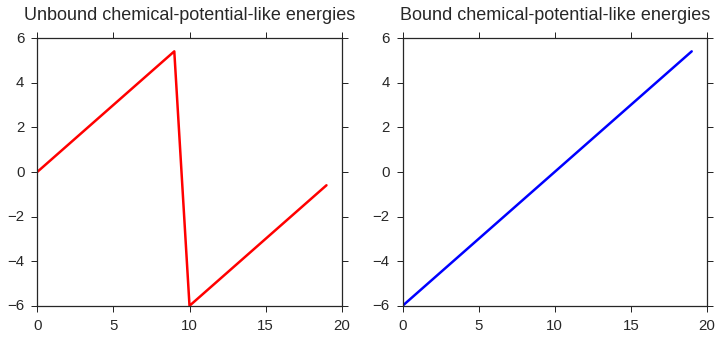

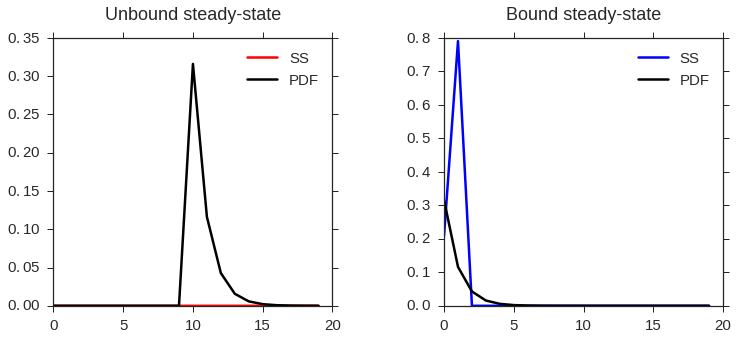

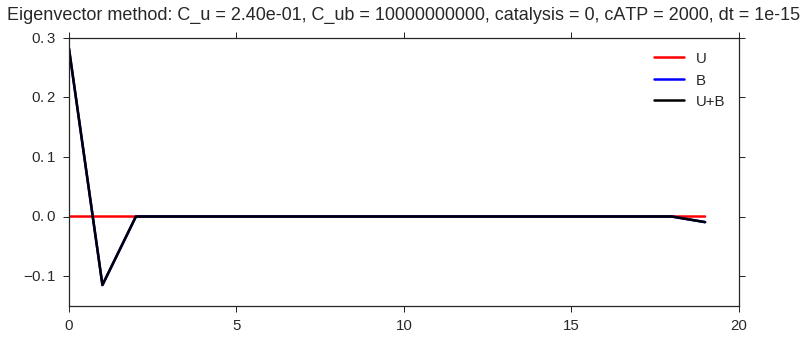

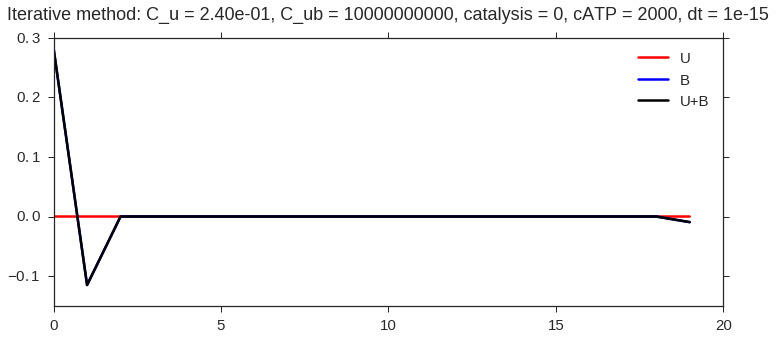

In [51]:
example = simulation()
example.catalytic_rate = 0
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.C_intrasurface = 0.24
example.cATP = 2000
example.iterations = 1000000
example.simulate(plot=True)

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


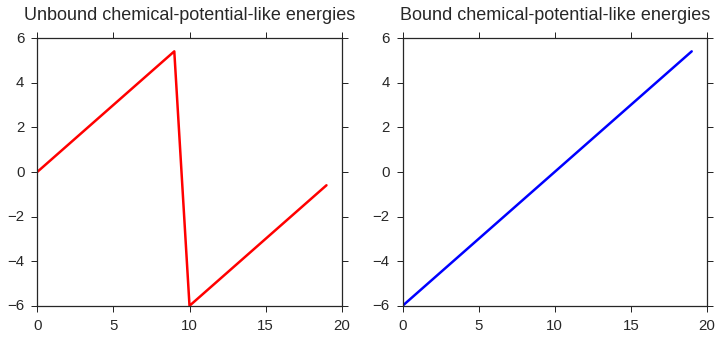

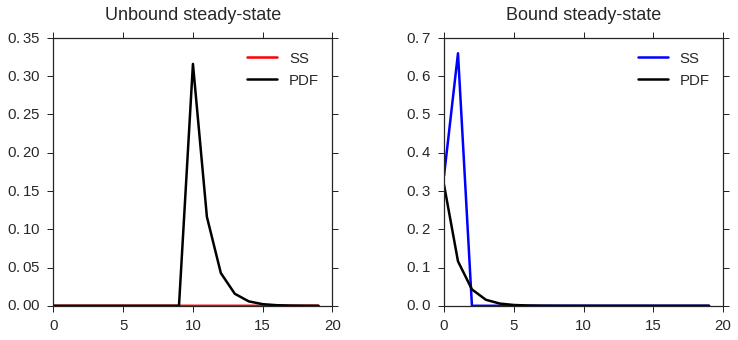

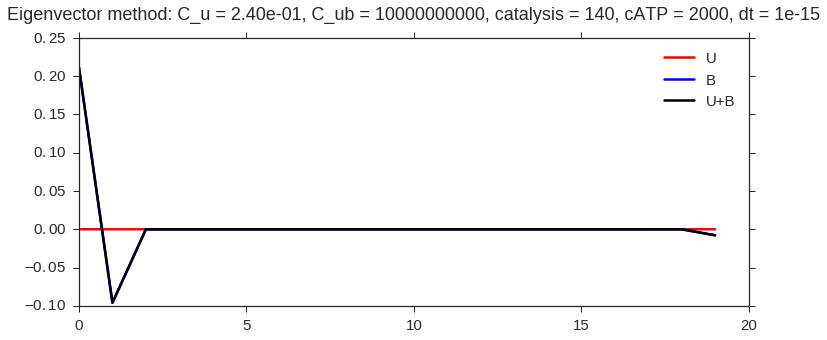

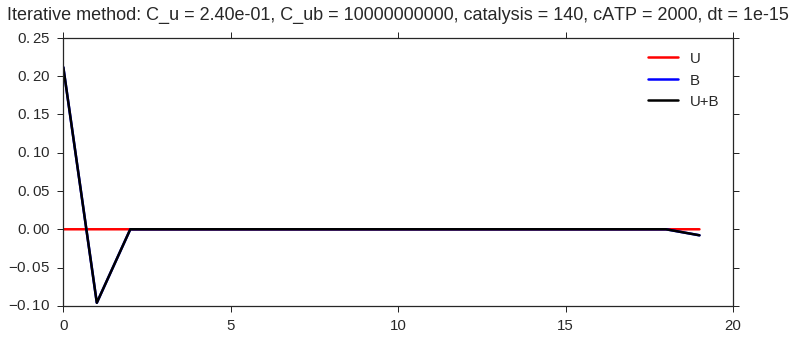

In [52]:
example = simulation()
example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
example.C_intrasurface = 0.24
example.cATP = 2000
example.iterations = 1000000
example.simulate(plot=True)

In [53]:
example.flux_b+example.flux_u

array([  2.11679577e-01,  -9.60773445e-02,  -1.39810886e-11,
        -1.68978068e-15,   7.12233898e-19,  -3.14944453e-16,
         3.73435716e-15,   3.89234826e-15,  -1.29823277e-15,
        -2.37231101e-16,   7.57709117e-18,  -3.48722860e-18,
         2.72806868e-18,   1.02941032e-15,   1.33569961e-16,
        -1.61799020e-16,   2.94713902e-17,   9.79342056e-15,
         1.16634709e-05,  -7.86498835e-03])

# Scan ATP

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


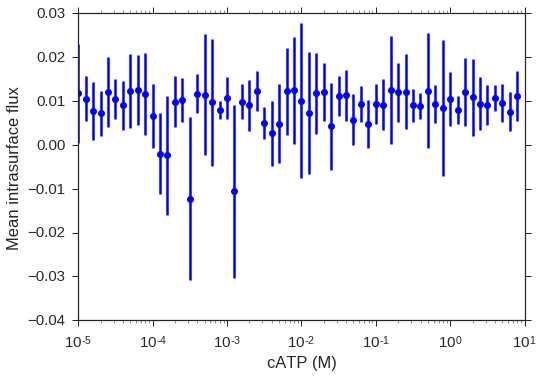

In [54]:
fig = plt.figure()
ax = plt.subplot(111)
for i in np.arange(-5, 1, 0.1):
    example = simulation()
    example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
    example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
    example.C_intrasurface = 0.24
    example.cATP = 10**i
    example.iterations = 0
    example.simulate(plot=False)
    ax.errorbar(10**i, np.mean(example.flux_u+example.flux_b), yerr=stats.sem(example.flux_u+example.flux_b), fmt='-o', c='b')

plt.ylabel('Mean intrasurface flux')
plt.xlabel('cATP (M)')
plt.xscale('log')
plt.show()
    

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


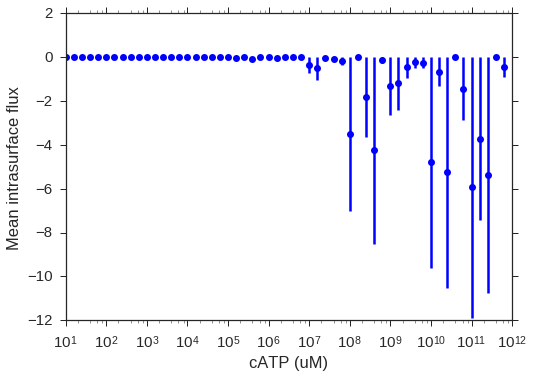

In [55]:
fig = plt.figure()
ax = plt.subplot(111)
for i in np.arange(1, 12, 0.2):
    example = simulation()
    example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
    example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
    example.C_intrasurface = 0.24
    example.cATP = 10**i
    example.iterations = 0
    example.simulate(plot=False)
    ax.errorbar(10**i, np.mean(example.flux_u+example.flux_b), yerr=stats.sem(example.flux_u+example.flux_b), fmt='-o', c='b')

plt.ylabel('Mean intrasurface flux')
plt.xlabel('cATP (uM)')
plt.xscale('log')
plt.show()
    

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


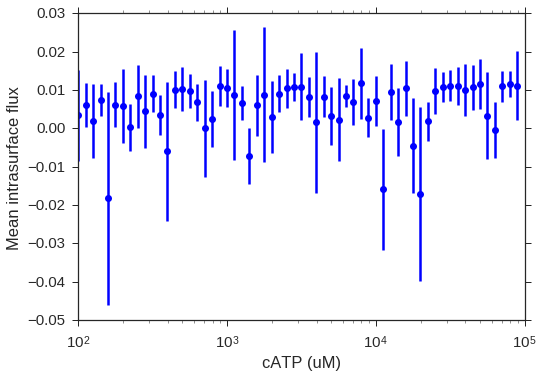

In [56]:
fig = plt.figure()
ax = plt.subplot(111)
for i in np.arange(2, 5, 0.05):
    example = simulation()
    example.unbound = np.array([variable_saw(12, i, 20) for i in range(20)])
    example.bound = np.array([variable_saw(12, i + 10, 20) for i in range(20)])
    example.C_intrasurface = 0.24
    example.cATP = 10**i
    example.iterations = 0
    example.simulate(plot=False)
    ax.errorbar(10**i, np.mean(example.flux_u+example.flux_b), yerr=stats.sem(example.flux_u+example.flux_b), fmt='-o', c='b')

plt.ylabel('Mean intrasurface flux')
plt.xlabel('cATP (M)')
plt.xscale('log')
plt.show()
    

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


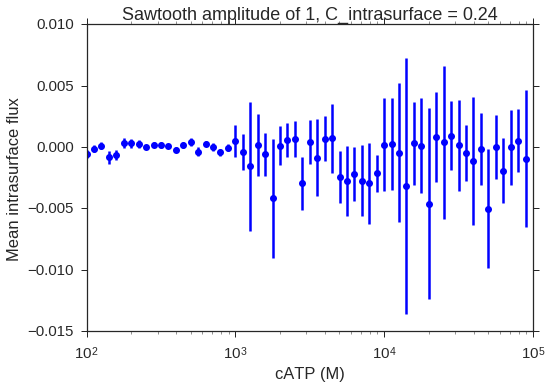

In [58]:
fig = plt.figure()
ax = plt.subplot(111)
for i in np.arange(2, 5, 0.05):
    example = simulation()
    example.unbound = np.array([variable_saw(1, i, 20) for i in range(20)])
    example.bound = np.array([variable_saw(1, i + 10, 20) for i in range(20)])
    example.C_intrasurface = 0.24
    example.cATP = 10**i
    example.iterations = 0
    example.simulate(plot=False)
    ax.errorbar(10**i, np.mean(example.flux_u+example.flux_b), yerr=stats.sem(example.flux_u+example.flux_b), fmt='-o', c='b')

plt.ylabel('Mean intrasurface flux')
plt.xlabel('cATP (M)')
plt.xscale('log')
plt.title('Sawtooth amplitude of 1, C_intrasurface = {}'.format(example.C_intrasurface))
plt.show()





# What kind of C_intrasurface value is large enough to give us flux but not so large that it generates numerical instabilities?

0.006228282747692336 +/- 0.03057285781064603
0.058732895774147816 +/- 0.08244262578161797
-0.07155465445462121 +/- 0.2141156357798802
0.0012429233269847758 +/- 0.12258882583456938
-0.43624458282355183 +/- 0.5897893836623076
-0.7058834195210565 +/- 0.9422173329797541
-1.2045230987961444 +/- 3.6415337080114965
-1.5534938568499863 +/- 2.6554448502730663
-1.3549687583002092 +/- 1.5099097982656378
-3.3979964556300044 +/- 7.519568442210176
-0.6101244721250136 +/- 3.9521895656090766
-7.777854447079836 +/- 5.780042769840087
-3.003144483666273 +/- 5.167592643428523
8.944440552763751 +/- 7.525032944736937
3.867433469344019 +/- 10.449891051516602
-23.963600284943706 +/- 11.82856284072448
0.937497903623614 +/- 12.164058833308026


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:156: ComplexWarning: Casting complex values to real discards the imaginary part


-48.6731823766821 +/- 12.636851409564049
-73.66153686372132 +/- 15.178069311371328
-11.442582103644789 +/- 32.65355426206621
-99.74501294867773 +/- 20.284751025123498
35.208508610857066 +/- 23.236076542350197
-149.22708932091766 +/- 34.909980807539945
-8.911586695443663 +/- 76.67903316227829
15.23694464568734 +/- 21.479610932139778
-77.667405401532 +/- 9.609218525875459
-141.14726152798386 +/- 17.310538533329563
-87.04764346143682 +/- 41.870141547481836
195.79191604334466 +/- 48.64257854216634
106.80781291115713 +/- 30.517126005193532
492.8771976643849 +/- 61.77820453210689
71.33796820530128 +/- 19.71861294869243
-225.2247610922499 +/- 39.84257582803953
-110.72614202496145 +/- 28.073789081121497
33.67708655140499 +/- 16.94360467882176
-85.66387002745567 +/- 13.371285184629924
-80.53260169525721 +/- 47.185654300513285
-116.52133071913886 +/- 28.247269746748117
700.9831065646118 +/- 125.50970199288506
-120.73707602044267 +/- 25.8540452491823
-22.368278304090317 +/- 21.008120079927007
220

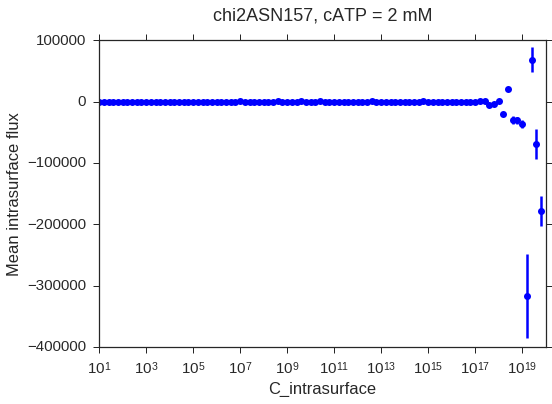

In [60]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi2ASN157'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

fig = plt.figure()
ax = plt.subplot(111)

for i in np.arange(1, 20, 0.2):

    this = simulation()
    this.bins = len(unbound)
    this.unbound = this.data_to_energy(unbound)
    this.bound = this.data_to_energy(bound)
    this.tm = np.zeros((this.bins, this.bins))
    # this.C_intrasurface = this.C_intrasurface_0 / (360. / this.bins)
    this.C_intrasurface = 10**i
    this.cATP = 2000 * 10**-6

    this.iterations = 0
    this.simulate(plot=False)
    print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))
    ax.errorbar(10**i, np.mean(this.flux_u+this.flux_b), yerr=stats.sem(this.flux_u+this.flux_b), fmt='-o', c='b')



plt.ylabel('Mean intrasurface flux')
plt.xlabel('C_intrasurface')
plt.xscale('log')
plt.title('chi2ASN157, cATP = 2 mM', y=1.05)
plt.show()









# Okay, scan through MD files!

## Catalysis **off**

In [91]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))
all_fluxes       = []
all_errs         = []
files            = []

for i in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    if name == 'chi1CYM185_chi_pop_hist_targ':
        continue
    else:
        unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1)
        bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
        unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
        bound_name = bound_files[i].split('/')[-1].split('_')[0]
        assert(unbound_name == bound_name)

        this = simulation()
        this.bins = len(unbound)
        this.unbound = this.data_to_energy(unbound) + this.offset_factor
        this.bound = this.data_to_energy(bound)
        this.tm = np.zeros((this.bins, this.bins))
        
        this.C_intrasurface = 10**10
        this.cATP = 2000 * 10**-6        
        this.C_intersurface = 0.24 * 10**6
        
        this.catalytic_rate = 0
        this.simulate()
        all_fluxes.append(np.mean(this.flux_u+this.flux_b))
        all_errs.append(stats.sem(this.flux_u+this.flux_b))
        files.append(unbound_name)
        del this

import pandas as pd
df_nocat = pd.DataFrame()
df_nocat['Name'] = files
df_nocat['Flux'] = all_fluxes
df_nocat['SEMs'] = all_errs

## Catalysis on

In [92]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))
all_fluxes       = []
all_errs         = []
files            = []

for i in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    if name == 'chi1CYM185_chi_pop_hist_targ':
        continue
    else:
        unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1) 
        bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
        unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
        bound_name = bound_files[i].split('/')[-1].split('_')[0]
        assert(unbound_name == bound_name)

        this = simulation()
        this.bins = len(unbound)
        this.unbound = this.data_to_energy(unbound) + this.offset_factor
        this.bound = this.data_to_energy(bound)
        this.tm = np.zeros((this.bins, this.bins))

        this.C_intrasurface = 10**10
        this.cATP = 2000 * 10**-6
        this.C_intersurface = 0.24 * 10**6
        
        this.catalytic_rate = 140
        this.simulate()
        all_fluxes.append(np.mean(this.flux_u+this.flux_b))
        all_errs.append(stats.sem(this.flux_u+this.flux_b))
        files.append(unbound_name)
        del this

import pandas as pd
df_cat = pd.DataFrame()
df_cat['Name'] = files
df_cat['Flux'] = all_fluxes
df_cat['SEMs'] = all_errs

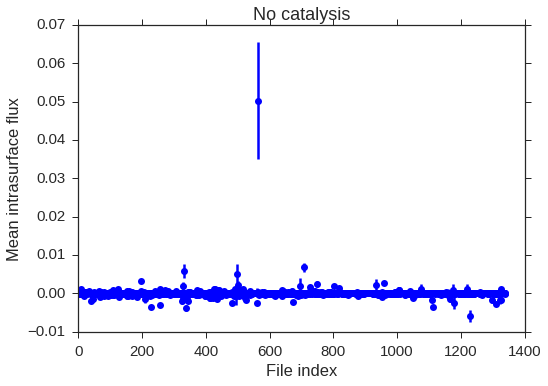

In [93]:
fig = plt.figure()
for i in range(len(df_nocat)):
        plt.errorbar(i, df_nocat['Flux'][i], yerr=df_nocat['SEMs'][i], fmt='-o', c='b')
plt.ylabel('Mean intrasurface flux')
plt.xlabel('File index')
plt.title('No catalysis')
plt.show()

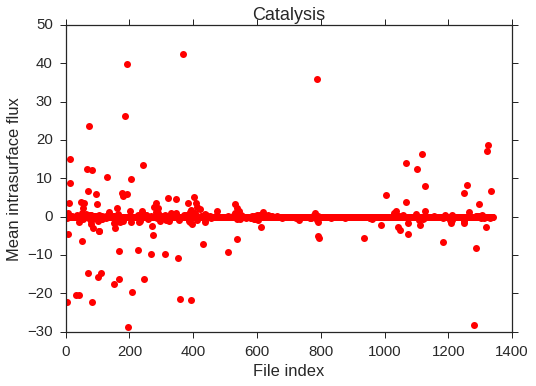

In [94]:
fig = plt.figure()
for i in range(len(df_nocat)):
        plt.errorbar(i, df_cat['Flux'][i], yerr=df_cat['SEMs'][i], fmt='-o', c='r')
plt.ylabel('Mean intrasurface flux')
plt.xlabel('File index')
plt.title('Catalysis')
plt.show()

In [98]:
ratio = pd.DataFrame()
ratio['With catalysis'] = df_cat['Flux']
ratio['Without catalysis'] = df_nocat['Flux']
ratio['Ratio'] = df_cat['Flux'] / df_nocat['Flux']
ratio['Filename'] = df_cat['Name']

In [99]:
ratio.sort_values('Ratio', ascending=False, inplace=True)
assert(df_cat['Name'][357] == df_nocat['Name'][357])

In [100]:
ratio

,With catalysis,Without catalysis,Ratio,Filename
83,-22.320350,-6.815484e-07,3.274947e+07,chi1GLU3
32,-20.300389,-1.280068e-06,1.585884e+07,chi1ASP152
1281,-28.233367,-2.607919e-06,1.082601e+07,psiSER311
614,-2.748586,-2.894058e-07,9.497345e+06,chi3MET104
13,14.998941,1.718823e-06,8.726287e+06,chi1ARG42
1204,-0.943334,-1.531108e-07,6.161119e+06,psiLYS271
1072,-4.596423,-8.271794e-07,5.556742e+06,psiCYM185
290,2.301984,5.483970e-07,4.197660e+06,chi1VAL43
353,-10.732604,-2.767572e-06,3.877986e+06,chi2GLN260
367,42.511955,1.395693e-05,3.045938e+06,chi2GLU194


In [83]:
print('With catalysis = {}, without catalysis = {} for {}'.format(df_cat['Flux'][357], df_nocat['Flux'][357], df_cat['Name'][357]))

With catalysis = -0.04221325779278307, without catalysis = -6.274700998668929e-06 for chi2GLN70


/home/dslochower/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


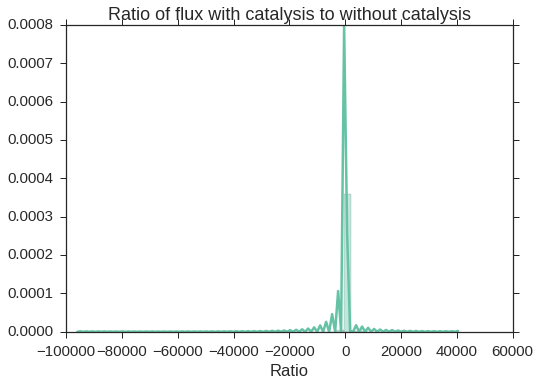

In [85]:
plt.figure()
sns.distplot(ratio['Ratio'])
plt.title('Ratio of flux with catalysis to without catalysis')

/home/dslochower/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


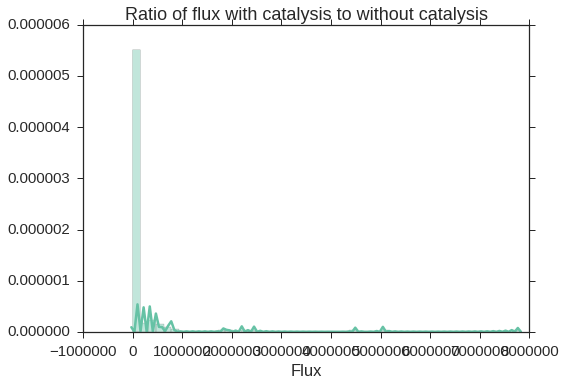

In [20]:
plt.figure()
sns.distplot(ratio[ratio>100])
plt.title('Ratio of flux with catalysis to without catalysis')


## Hey, let's take a closer look at chi1GLU3

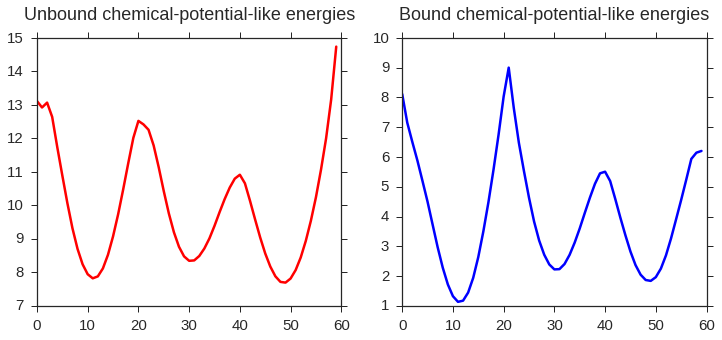

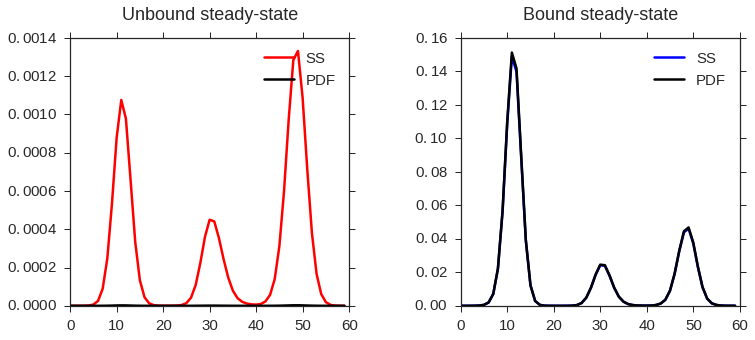

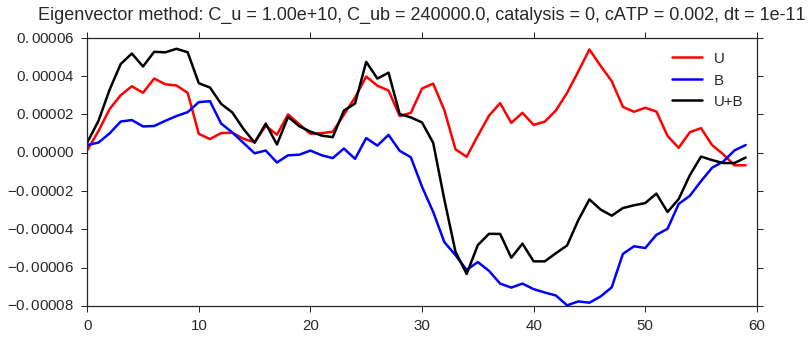

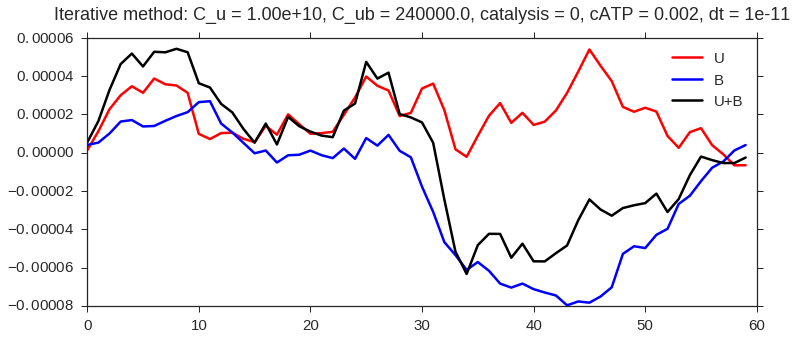

Flux = -6.81548360148554e-07 +/- 4.457354275457344e-06


In [108]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1GLU3'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound) + this.offset_factor
this.bound = this.data_to_energy(bound)
this.tm = np.zeros((this.bins, this.bins))

this.C_intersurface = 0.24 * 10**6
this.C_intrasurface = 10**10
this.catalytic_rate = 0
this.cATP = 2000*10**-6


this.iterations = 0
this.simulate(plot=True)

print('Flux = {} +/- {}'.format(np.mean(this.flux_b+this.flux_u), sc.stats.sem(this.flux_b+this.flux_u)))

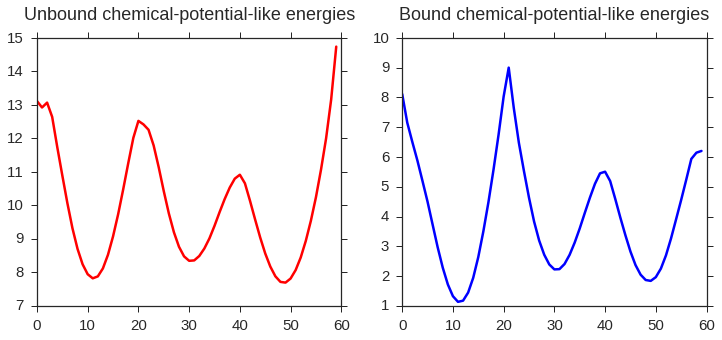

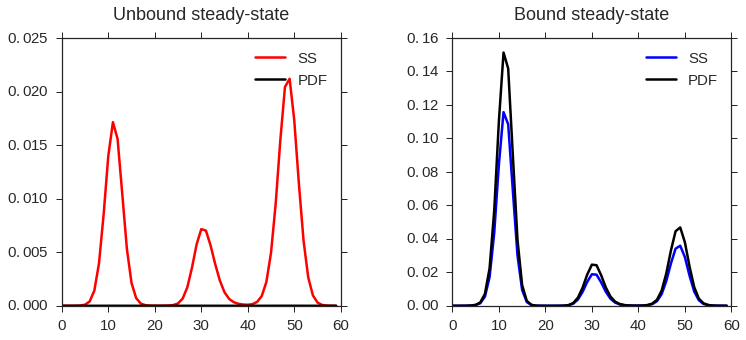

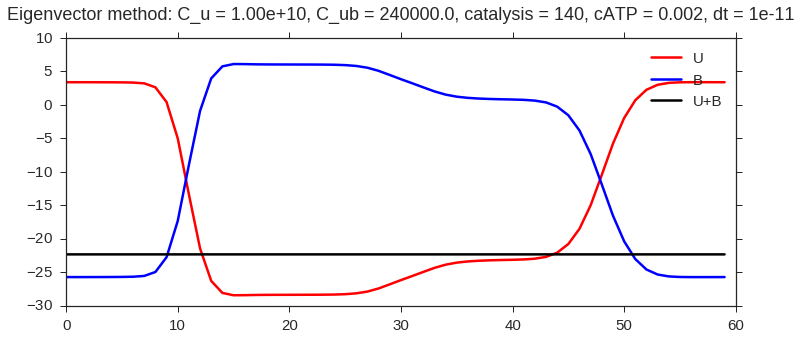

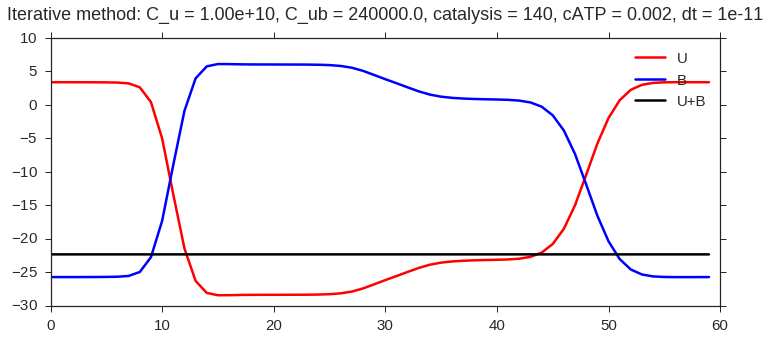

Flux = -22.320332934732505 +/- 6.0376029969642435e-06


In [107]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

name = 'chi1GLU3'
unbound_files = dir+'apo/'+name+'_chi_pop_hist_targ.txt'
bound_files = dir+'atpmg/'+name+'_chi_pop_hist_ref.txt'
unbound = genfromtxt(unbound_files, delimiter=',', skip_header=1)
bound = genfromtxt(bound_files, delimiter=',', skip_header=1)

this = simulation()
this.bins = len(unbound)
this.unbound = this.data_to_energy(unbound) + this.offset_factor
this.bound = this.data_to_energy(bound)
this.tm = np.zeros((this.bins, this.bins))

this.C_intersurface = 0.24 * 10**6
this.C_intrasurface = 10**10
this.catalytic_rate = 140
this.cATP = 2000*10**-6

this.iterations = 0
this.simulate(plot=True)

print('Flux = {} +/- {}'.format(np.mean(this.flux_b+this.flux_u), sc.stats.sem(this.flux_b+this.flux_u)))

In [105]:
np.mean(this.flux_b+this.flux_u)

-22.320349624944249